# Quora Insincere Questions Kaggle EDA
### Kevin Sun
References:
* https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc

In [1]:
# Usual imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from statistics import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import textstat
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import os

# Plotly based imports for visualization
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [2]:
df_train = pd.read_csv("data/train.csv")
print(df_train.shape)
df_train.head()

(1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [3]:
df_test = pd.read_csv("data/test.csv")
print(df_test.shape)
df_test.head()

(56370, 2)


,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $20...
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


In [4]:

## target count ##
cnt_srs = df_train['target'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

### Wordcloud analysis
word frequency ploy of sincere and insincere questions
* Some of the top words are common across both the classes like 'people', 'will', 'think' etc
* The other top words in sincere questions after excluding the common ones at the very top are 'best', 'good' etc
* The other top words in insincere questions after excluding the common ones are 'trump', 'women', 'white' etc

bigram frequency plots

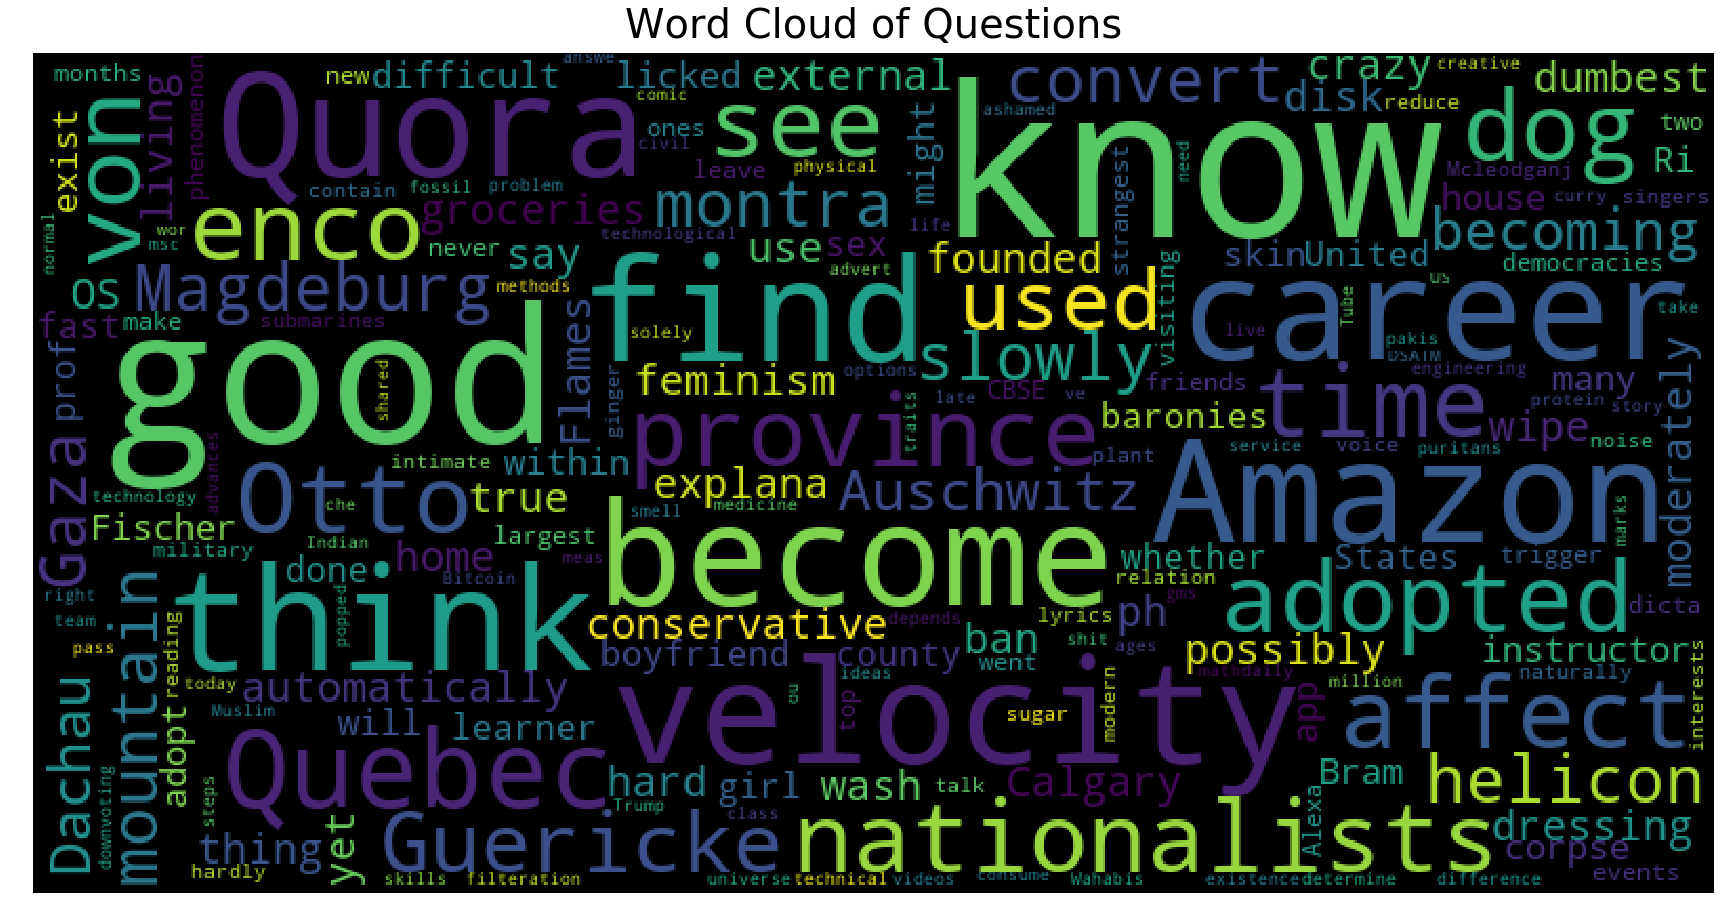

In [5]:

from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df_train["question_text"], title="Word Cloud of Questions")

In [6]:
from collections import defaultdict
df_train1 = df_train[df_train["target"]==1]
df_train0 = df_train[df_train["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in df_train0["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted10 = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted10.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted10.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in df_train1["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted11 = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted11.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted11.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

#plt.figure(figsize=(10,16))
#sns.barplot(x="ngram_count", y="ngram", data=fd_sorted.loc[:50,:], color="b")
#plt.title("Frequent words for Insincere Questions", fontsize=16)
#plt.show()

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [7]:
freq_dict = defaultdict(int)
for sent in df_train0["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted20 = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted20.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted20.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in df_train1["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted21 = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted21.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted21.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere questions", 
                                          "Frequent bigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [8]:
freq_dict = defaultdict(int)
for sent in df_train0["question_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted30 = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted30.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted30.head(50), 'green')


freq_dict = defaultdict(int)
for sent in df_train1["question_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted31 = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted31.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted31.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams of sincere questions", 
                                          "Frequent trigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### Meta Features:

Now let us create some meta features and then look at how they are distributed between the classes. The ones that we will create are

1. Number of words in the text
2. Number of unique words in the text
3. Number of characters in the text
4. Number of stopwords
5. Number of punctuations
6. Number of upper case words
7. Number of title case words
8. Average length of the words

In [9]:
## Number of words in the text ##
df_train["num_words"] = df_train["question_text"].apply(lambda x: len(str(x).split()))
df_test["num_words"] = df_test["question_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
df_train["num_unique_words"] = df_train["question_text"].apply(lambda x: len(set(str(x).split())))
df_test["num_unique_words"] = df_test["question_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
df_train["num_chars"] = df_train["question_text"].apply(lambda x: len(str(x)))
df_test["num_chars"] = df_test["question_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
df_train["num_stopwords"] = df_train["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test["num_stopwords"] = df_test["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
df_train["num_punctuations"] =df_train['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
df_test["num_punctuations"] =df_test['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
df_train["num_words_upper"] = df_train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
df_test["num_words_upper"] = df_test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
df_train["num_words_title"] = df_train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
df_test["num_words_title"] = df_test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
df_train["mean_word_len"] = df_train["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test["mean_word_len"] = df_test["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [10]:
# ## Flesch Reading Ease ##
# df_train["fre"] = df_train["question_text"].apply(lambda x: textstat.flesch_reading_ease(x))
# df_test["fre"] = df_test["question_text"].apply(lambda x: textstat.flesch_reading_ease(x))

# ## Flesch-Kincaid Grade Level ##
# df_train["fkg"] = df_train["question_text"].apply(lambda x: textstat.flesch_kincaid_grade(x))
# df_test["fkg"] = df_test["question_text"].apply(lambda x: textstat.flesch_kincaid_grade(x))

# ## Gunning FOG Scale ##
# df_train["fog"] = df_train["question_text"].apply(lambda x: textstat.gunning_fog(x))
# df_test["fog"] = df_test["question_text"].apply(lambda x: textstat.gunning_fog(x))

# ## Automated Redability Index ##
# df_train["ari"] = df_train["question_text"].apply(lambda x: textstat.automated_readability_index(x))
# df_test["ari"] = df_test["question_text"].apply(lambda x: textstat.automated_readability_index(x))

# ## Coleman-Liau Index ##
# df_train["cli"] = df_train["question_text"].apply(lambda x: textstat.coleman_liau_index(x))
# df_test["cli"] = df_test["question_text"].apply(lambda x: textstat.coleman_liau_index(x))

# ## Linsear Write Formula ##
# df_train["lwf"] = df_train["question_text"].apply(lambda x: textstat.linsear_write_formula(x))
# df_test["lwf"] = df_test["question_text"].apply(lambda x: textstat.linsear_write_formula(x))

# ## Dale-Chall Readability Score ##
# df_train["dcr"] = df_train["question_text"].apply(lambda x: textstat.dale_chall_readability_score(x))
# df_test["dcr"] = df_test["question_text"].apply(lambda x: textstat.dale_chall_readability_score(x))

# def consensus_all(text):
#     return textstat.text_standard(text,float_output=True)

# ## Cnsensus for estimated school grade level to understand text based upon all the above tests ##
# df_train["con"] = df_train["question_text"].apply(lambda x: consensus_all(x))
# df_test["con"] = df_test["question_text"].apply(lambda x: consensus_all(x))

In [11]:
df_train.head()

,qid,question_text,target,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,13,72,7,1,0,2,4.615385
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,15,81,10,2,0,1,4.125000
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,8,67,3,2,0,2,5.800000
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,9,57,3,1,0,4,5.444444
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,15,77,7,1,2,3,4.200000


In [12]:
# df_train.to_csv("data/df_train.csv", index=False)
# df_test.to_csv("data/df_test.csv", index=False)
df_train = pd.read_csv("data/df_train.csv")
df_test = pd.read_csv("data/df_test.csv")

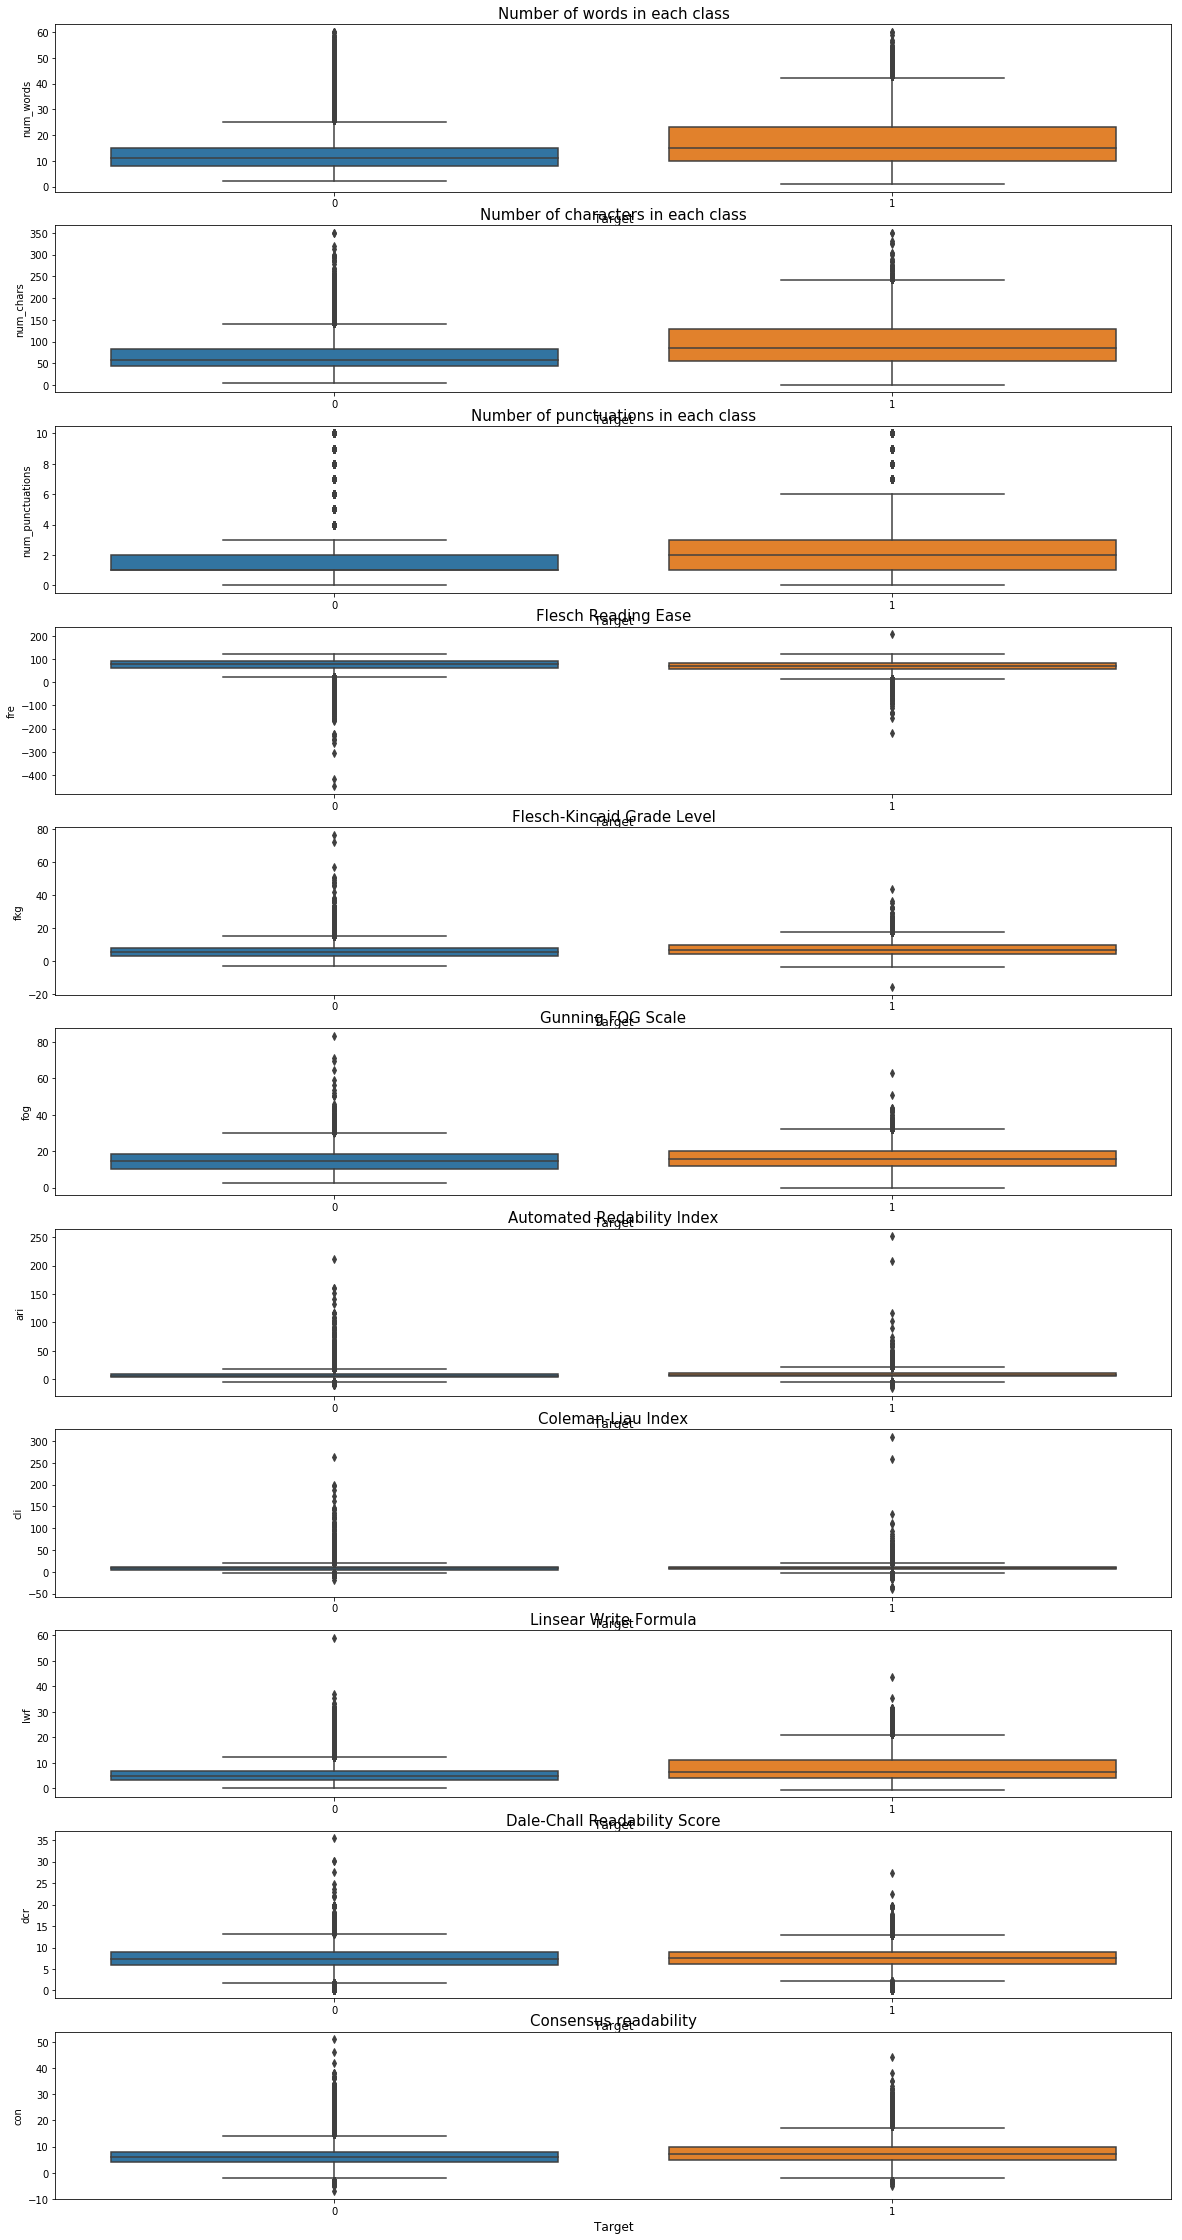

In [13]:
## Truncate some extreme values for better visuals ##
df_train['num_words'].loc[df_train['num_words']>60] = 60 #truncation for better visuals
df_train['num_punctuations'].loc[df_train['num_punctuations']>10] = 10 #truncation for better visuals
df_train['num_chars'].loc[df_train['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(11, 1, figsize=(20,40))
sns.boxplot(x='target', y='num_words', data=df_train, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='num_chars', data=df_train, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='target', y='num_punctuations', data=df_train, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
#plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)

sns.boxplot(x='target', y='fre', data=df_train, ax=axes[3])
axes[3].set_xlabel('Target', fontsize=12)
axes[3].set_title("Flesch Reading Ease", fontsize=15)

sns.boxplot(x='target', y='fkg', data=df_train, ax=axes[4])
axes[4].set_xlabel('Target', fontsize=12)
axes[4].set_title("Flesch-Kincaid Grade Level", fontsize=15)

sns.boxplot(x='target', y='fog', data=df_train, ax=axes[5])
axes[5].set_xlabel('Target', fontsize=12)
axes[5].set_title("Gunning FOG Scale", fontsize=15)

sns.boxplot(x='target', y='ari', data=df_train, ax=axes[6])
axes[6].set_xlabel('Target', fontsize=12)
axes[6].set_title("Automated Redability Index", fontsize=15)

sns.boxplot(x='target', y='cli', data=df_train, ax=axes[7])
axes[7].set_xlabel('Target', fontsize=12)
axes[7].set_title("Coleman-Liau Index", fontsize=15)

sns.boxplot(x='target', y='lwf', data=df_train, ax=axes[8])
axes[8].set_xlabel('Target', fontsize=12)
axes[8].set_title("Linsear Write Formula", fontsize=15)

sns.boxplot(x='target', y='dcr', data=df_train, ax=axes[9])
axes[9].set_xlabel('Target', fontsize=12)
axes[9].set_title("Dale-Chall Readability Score", fontsize=15)

sns.boxplot(x='target', y='con', data=df_train, ax=axes[10])
axes[10].set_xlabel('Target', fontsize=12)
axes[10].set_title("Consensus readability", fontsize=15)
plt.show()

In [14]:
stopwords = set(STOPWORDS)
more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
stopwords = stopwords.union(more_stopwords)

for n in ['10', '11', '20', '21', '30', '31']:
    fd_sorted = eval('fd_sorted' + n)
    count = 1
    for i in range(len(fd_sorted)):
        word = fd_sorted['word'][i]
        if(n in ['10', '11']):
            if(word not in stopwords):
                df_train["has_" + word.replace(' ', '_')] = df_train["question_text"].apply(lambda x: word in x)
                df_test["has_" + word.replace(' ', '_')] = df_test["question_text"].apply(lambda x: word in x)
                count += 1
        else:
            df_train["has_" + word.replace(' ', '_')] = df_train["question_text"].apply(lambda x: word in x)
            df_test["has_" + word.replace(' ', '_')] = df_test["question_text"].apply(lambda x: word in x)
            count += 1
        if(count == 10):
            break

In [15]:
df_train.columns

Index(['qid', 'question_text', 'target', 'num_words', 'num_unique_words',
       'num_chars', 'num_stopwords', 'num_punctuations', 'num_words_upper',
       'num_words_title', 'mean_word_len', 'fre', 'fkg', 'ari', 'cli', 'dcr',
       'con', 'fog', 'lwf', 'has_best', 'has_will', 'has_people', 'has_good',
       'has_make', 'has_think', 'has_many', 'has_much', 'has_someone',
       'has_trump', 'has_women', 'has_white', 'has_men', 'has_indian',
       'has_best_way', 'has_year_old', 'has_will_happen', 'has_many_people',
       'has_computer_science', 'has_even_though', 'has_known_for?',
       'has_united_states', 'has_long_take', 'has_donald_trump',
       'has_white_people', 'has_black_people', 'has_trump_supporters',
       'has_president_trump', 'has_tips_someone_starting',
       'has_someone_starting_work', 'has_useful_tips_someone',
       'has_advice_give_someone', 'has_short-term_business_travelers',
       'has_hotels_short-term_business', 'has_good_hotels_short-term',
       

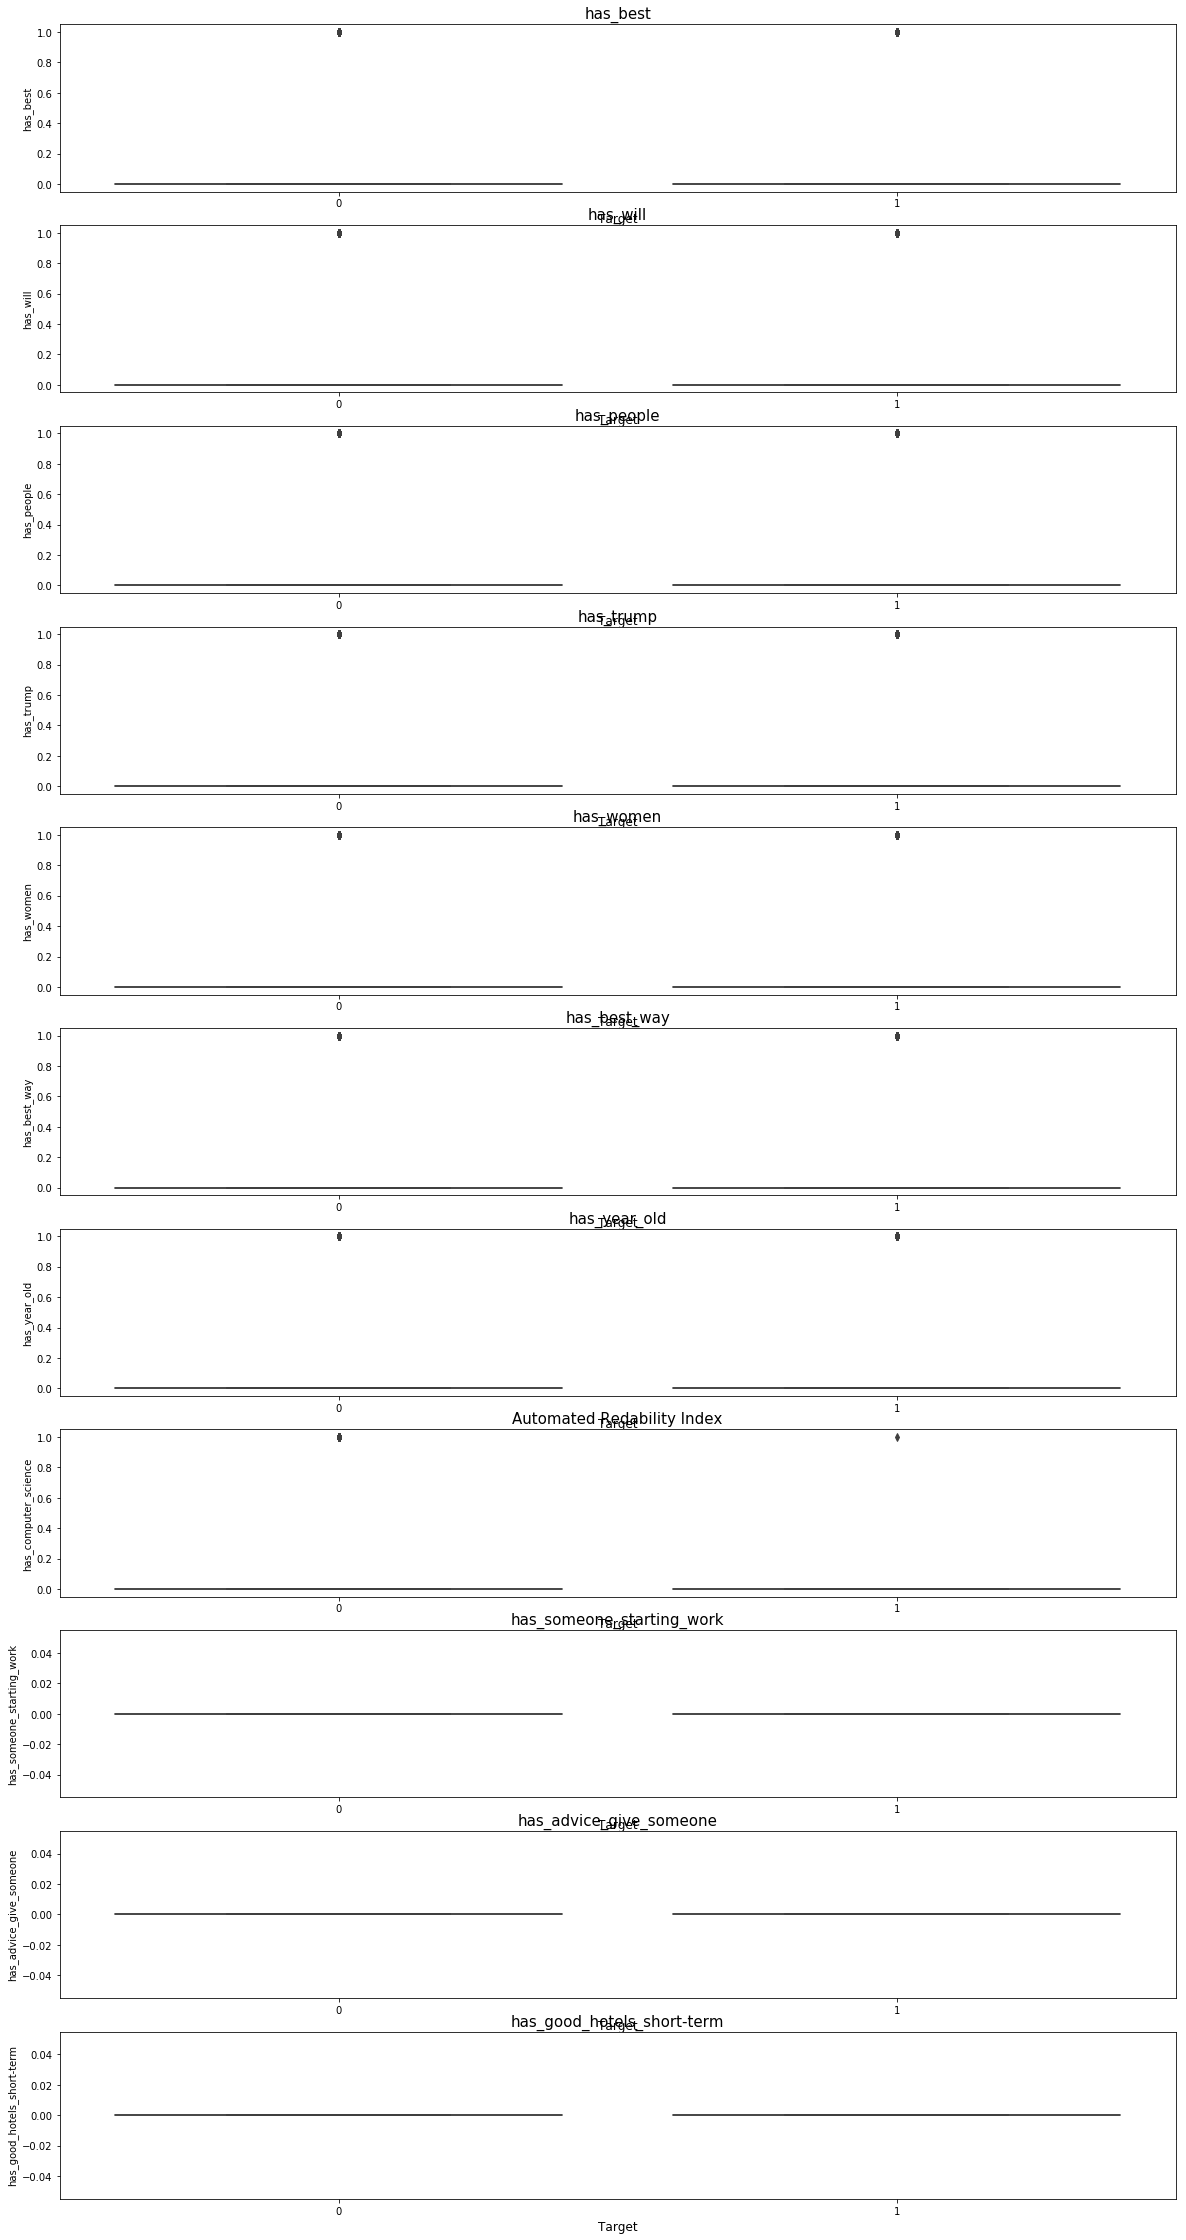

In [23]:
f, axes = plt.subplots(11, 1, figsize=(20,40))
sns.boxplot(x='target', y='has_best', data=df_train, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("has_best", fontsize=15)

sns.boxplot(x='target', y='has_will', data=df_train, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("has_will", fontsize=15)

sns.boxplot(x='target', y='has_people', data=df_train, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
#plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("has_people", fontsize=15)

sns.boxplot(x='target', y='has_trump', data=df_train, ax=axes[3])
axes[3].set_xlabel('Target', fontsize=12)
axes[3].set_title("has_trump", fontsize=15)

sns.boxplot(x='target', y='has_women', data=df_train, ax=axes[4])
axes[4].set_xlabel('Target', fontsize=12)
axes[4].set_title("has_women", fontsize=15)

sns.boxplot(x='target', y='has_best_way', data=df_train, ax=axes[5])
axes[5].set_xlabel('Target', fontsize=12)
axes[5].set_title("has_best_way", fontsize=15)

sns.boxplot(x='target', y='has_year_old', data=df_train, ax=axes[6])
axes[6].set_xlabel('Target', fontsize=12)
axes[6].set_title("has_year_old", fontsize=15)

sns.boxplot(x='target', y='has_computer_science', data=df_train, ax=axes[7])
axes[7].set_xlabel('Target', fontsize=12)
axes[7].set_title("Automated Redability Index", fontsize=15)

sns.boxplot(x='target', y='has_someone_starting_work', data=df_train, ax=axes[8])
axes[8].set_xlabel('Target', fontsize=12)
axes[8].set_title("has_someone_starting_work", fontsize=15)

sns.boxplot(x='target', y='has_advice_give_someone', data=df_train, ax=axes[9])
axes[9].set_xlabel('Target', fontsize=12)
axes[9].set_title("has_advice_give_someone", fontsize=15)

sns.boxplot(x='target', y='has_good_hotels_short-term', data=df_train, ax=axes[10])
axes[10].set_xlabel('Target', fontsize=12)
axes[10].set_title("has_good_hotels_short-term", fontsize=15)
plt.show()

In [39]:
for i in df_train.columns.values:
    if 'has' in i:
        r1 = len(df_train.loc[(df_train[i] == True) & df_train['target'].isin([0])])/len(df_train.loc[df_train['target'].isin([0])])
        r2 = len(df_train.loc[(df_train[i] == True) & df_train['target'].isin([1])])/len(df_train.loc[df_train['target'].isin([1])])
        print(i, r1, r2)
        
        

has_best 0.05029494528740435 0.008736542507115455
has_will 0.026189248126191535 0.04165326073505754
has_people 0.033308251286203024 0.13995792599925752
has_good 0.029896059126165418 0.017943323846058658
has_make 0.025724060484186885 0.02974879346615518
has_think 0.02007570316784623 0.050389803242173
has_many 0.018944562690971768 0.04576166316049994
has_much 0.017211126635501815 0.023858433362207648
has_someone 0.01724213914496879 0.010654621952728623
has_trump 0.00028074482254315634 0.002883306521470115
has_women 0.005552871431929174 0.06419997525058779
has_white 0.003031880859732052 0.04020542012127212
has_men 0.06599625238306651 0.14495730726395248
has_indian 2.2035204094957038e-05 0.0006806088355401559
has_best_way 0.006893754407040819 0.0015344635564905334
has_year_old 0.0027470554438379776 0.0043063977230540776
has_will_happen 0.001787299887702071 0.0011137235490657096
has_many_people 0.001582454101485989 0.004652889493874521
has_computer_science 0.0015106356585098326 1.2374706100